
[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
Optimized Random Forest -> RMSE: 13643.15, R²: 0.939
Time-Series CV R² Scores: [0.62315989 0.75308731 0.90444008]
Mean CV R²: 0.7602290920879788
Mediator Model RMSE: 15457.195324778892
Mediator Model R²: 0.9219003764630286


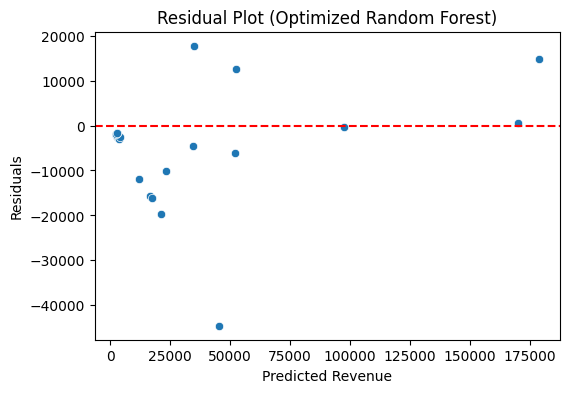

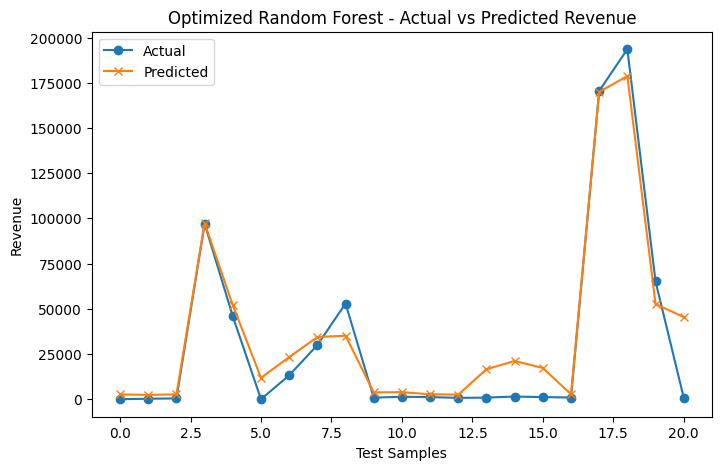

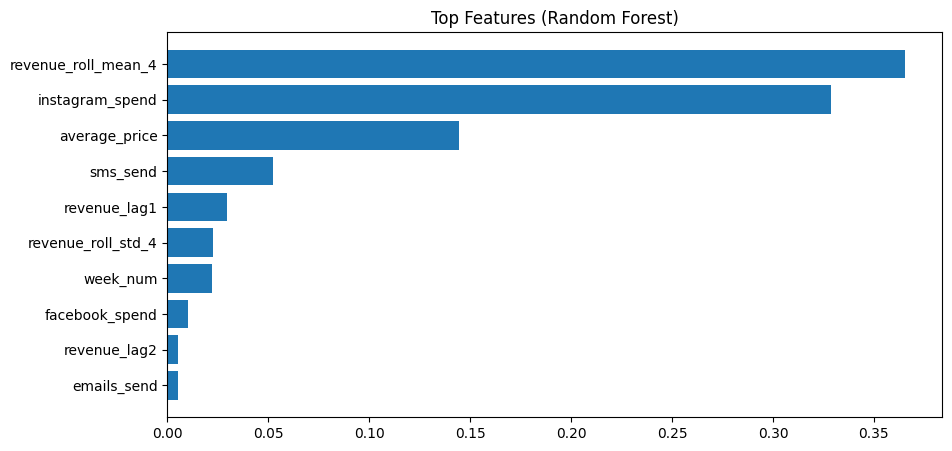

c:\Users\rajpu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


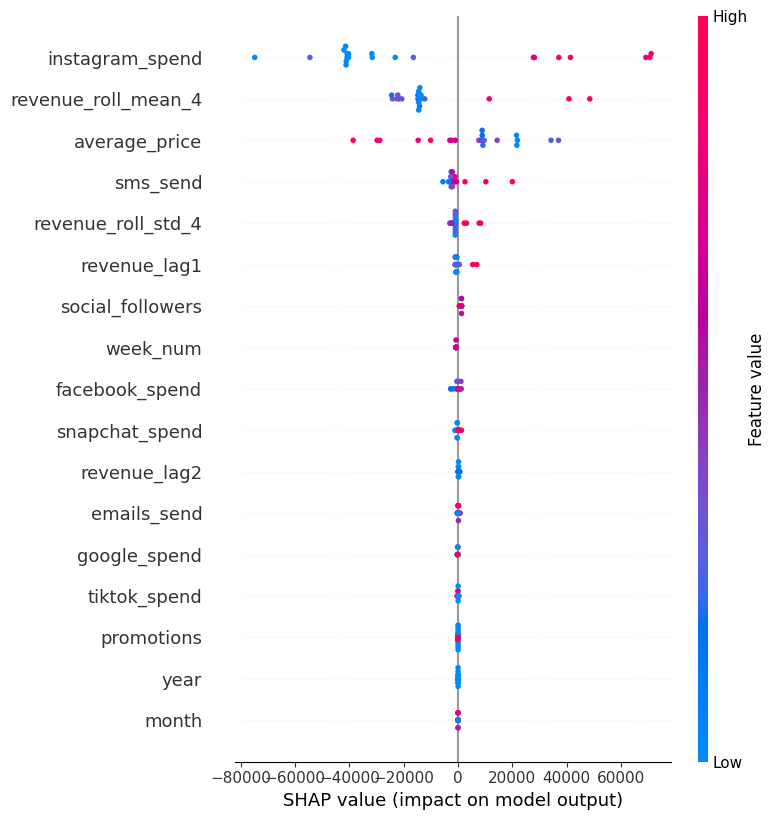

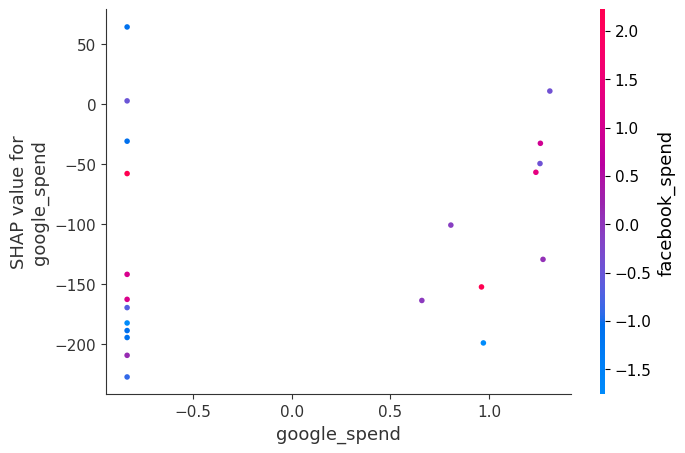

C:\Users\rajpu\AppData\Local\Temp\ipykernel_36368\3067416654.py:246: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


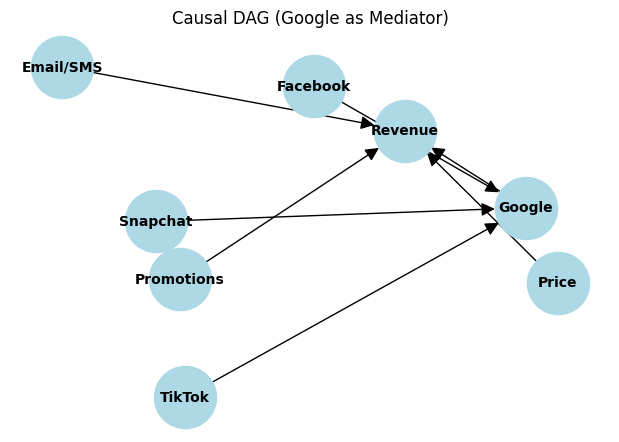

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install pandas numpy matplotlib seaborn scikit-learn shap graphviz networkx
import seaborn as sns



from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ===========================
# 1. Load Dataset
# ===========================
file_path = "../data/Assessment 2 - MMM Weekly.csv"
df = pd.read_csv(file_path)

# ===========================
# 2. Preprocessing & Feature Engineering
# ===========================
# Convert 'week' to datetime
df["week"] = pd.to_datetime(df["week"], errors="coerce")

# Extract temporal features
df["year"] = df["week"].dt.year
df["month"] = df["week"].dt.month
df["week_num"] = df["week"].dt.isocalendar().week

# Drop original 'week' column
df = df.drop(columns=["week"])

# Fill missing values (avoiding FutureWarning)
df = df.bfill().fillna(0)

# Lag & rolling features
df["revenue_lag1"] = df["revenue"].shift(1).bfill()
df["revenue_lag2"] = df["revenue"].shift(2).bfill()
df["revenue_roll_mean_4"] = df["revenue"].rolling(4, min_periods=1).mean()
df["revenue_roll_std_4"] = df["revenue"].rolling(4, min_periods=1).std().fillna(0)

# Define features and target
y = df["revenue"].values
X = df.drop(columns=["revenue"]).values
feature_names = df.drop(columns=["revenue"]).columns

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (keep temporal order)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# ===========================
# 3. Hyperparameter Tuning
# ===========================
param_grid = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
}

rf = RandomForestRegressor(random_state=42)

search = RandomizedSearchCV(
    rf,
    param_grid,
    n_iter=20,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    random_state=42
)
search.fit(X_train, y_train)

print("Best Hyperparameters:", search.best_params_)

# ===========================
# 4. Train Optimized Random Forest
# ===========================
rf_model = RandomForestRegressor(**search.best_params_, random_state=42)
rf_model.fit(X_train, y_train)

# ===========================
# 5. Evaluation
# ===========================
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized Random Forest -> RMSE: {rmse:.2f}, R²: {r2:.3f}")

# ===========================
# 6. Time-Series Cross Validation
# ===========================
tscv = TimeSeriesSplit(n_splits=3)
rf_cv = RandomForestRegressor(**search.best_params_, random_state=42)
cv_scores = cross_val_score(rf_cv, X_scaled, y, cv=tscv, scoring="r2", n_jobs=-1)

print("Time-Series CV R² Scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

# ===========================
# 7. Causal Framing (Google as Mediator)
# ===========================
if "google_spend" in df.columns:
    social_vars = ["facebook_spend", "tiktok_spend", "snapchat_spend"]
    google_var = "google_spend"

    X_social = df[social_vars].values
    y_google = df[google_var].values

    google_model = RandomForestRegressor(random_state=42, n_estimators=500)
    google_model.fit(X_social, y_google)
    df["google_pred"] = google_model.predict(X_social)

    # Replace actual google with predicted
    mediator_features = [col for col in df.columns if col not in ["revenue", google_var]]
    X_mediator = df[mediator_features].values
    y_revenue = df["revenue"].values

    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
        X_mediator, y_revenue, test_size=0.2, shuffle=False
    )

    rf_mediator = RandomForestRegressor(random_state=42, n_estimators=500)
    rf_mediator.fit(X_train_m, y_train_m)
    y_pred_mediator = rf_mediator.predict(X_test_m)

    print("Mediator Model RMSE:", np.sqrt(mean_squared_error(y_test_m, y_pred_mediator)))
    print("Mediator Model R²:", r2_score(y_test_m, y_pred_mediator))

# ===========================
# 8. Diagnostics & Visualizations
# ===========================
def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, label="Actual", marker="o")
    plt.plot(y_pred, label="Predicted", marker="x")
    plt.legend()
    plt.title(f"{model_name} - Actual vs Predicted Revenue")
    plt.xlabel("Test Samples")
    plt.ylabel("Revenue")
    plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot (Optimized Random Forest)")
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.show()

plot_results(y_test, y_pred, "Optimized Random Forest")

# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top Features (Random Forest)")
plt.show()

# ===========================
# 9. Sensitivity Analysis (Price & Promotions)
# ===========================
def sensitivity_analysis(model, X, feature_names, feature, values):
    base = X.mean(axis=0).reshape(1, -1)
    idx = list(feature_names).index(feature)
    preds = []

    for v in values:
        temp = base.copy()
        temp[0, idx] = v
        preds.append(model.predict(temp)[0])

    plt.plot(values, preds, marker="o")
    plt.title(f"Sensitivity of Revenue to {feature}")
    plt.xlabel(feature)
    plt.ylabel("Predicted Revenue")
    plt.show()

if "price" in df.columns and "promotions" in df.columns:
    sensitivity_analysis(
        rf_model, X_scaled, feature_names,
        "price", np.linspace(df["price"].min(), df["price"].max(), 20)
    )
    sensitivity_analysis(
        rf_model, X_scaled, feature_names,
        "promotions", np.linspace(df["promotions"].min(), df["promotions"].max(), 20)
    )

# ===========================
# 10. Explainability (SHAP)
# ===========================
import shap
explainer = shap.TreeExplainer(rf_model)

# Use smaller sample for performance
X_sample = X_test[:200]
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

if "google_spend" in feature_names:
    shap.dependence_plot("google_spend", shap_values, X_sample, feature_names=feature_names)

# ===========================
# 11. Causal DAG Visualization
# ===========================
import networkx as nx

# Build the DAG
G = nx.DiGraph()
G.add_edges_from([
    ("Facebook", "Google"),
    ("TikTok", "Google"),
    ("Snapchat", "Google"),
    ("Google", "Revenue"),
    ("Email/SMS", "Revenue"),
    ("Price", "Revenue"),
    ("Promotions", "Revenue"),
])

# Draw and save
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)  # layout algorithm
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue",
        arrowsize=20, font_size=10, font_weight="bold")
plt.title("Causal DAG (Google as Mediator)")
plt.tight_layout()
plt.savefig("../outputs/plots/mediation_dag.png", dpi=300)
plt.show()

